# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

seed = 85
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [ ]:
data = np.load("/kaggle/input/dataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
def calculate_class_proportions(label, num_classes):
    """
    Calculate the proportion of each class in a semantic segmentation label image.
    Args:
        label (numpy array): Label image (height, width).
        num_classes (int): Total number of classes.
    Returns:
        dict: Dictionary with class indices as keys and proportions as values.
    """
    total_pixels = label.size  # Total number of pixels in the image
    proportions = {}

    for class_id in range(num_classes):
        class_pixels = np.sum(label == class_id)  # Count pixels of the current class
        proportions[class_id] = class_pixels / total_pixels  # Proportion of this class

    return proportions

# Calculate aliens-images class proportions
num_classes = 5  # Background, Soil, Bedrock, Sand, Big Rock
example_label = y_train[1092]

aliens_proportions = calculate_class_proportions(example_label, num_classes)
print("Class Proportions:", aliens_proportions)

X_train_filtered = []
y_train_filtered = []
X_outliers = []
y_outliers = []

filtered_indices = []
for i, label in enumerate(y_train):
    proportions = calculate_class_proportions(label, num_classes=5)
    if proportions == aliens_proportions:
        X_outliers.append(X_train[i])
        y_outliers.append(y_train[i])
    else:
        X_train_filtered.append(X_train[i])
        y_train_filtered.append(y_train[i])



print(f"Numero di campioni originali: {len(X_train)}")
print(f"Numero di campioni filtrati: {len(X_train_filtered)}")

Class Proportions: {0: 0.530517578125, 1: 0.192626953125, 2: 0.0966796875, 3: 0.18017578125, 4: 0.0}
Numero di campioni originali: 2615
Numero di campioni filtrati: 2505


In [ ]:
X_train = np.array(X_train_filtered)
y_train = np.array(y_train_filtered)

print(f"Shape di X_train_filtered: {X_train.shape}")
print(f"Shape di y_train_filtered: {y_train.shape}")

Shape di X_train_filtered: (2505, 64, 128)
Shape di y_train_filtered: (2505, 64, 128)


In [ ]:

num_classes = 5

class_pixel_counts = np.zeros(num_classes, dtype=np.int64)

for mask in y_train:
    unique, counts = np.unique(mask, return_counts=True)
    for cls, count in zip(unique, counts):
        if 0 <= cls < num_classes:
            class_pixel_counts[int(cls)] += count

total_pixels = np.sum(class_pixel_counts)
background_pixels = class_pixel_counts[0]
non_background_pixels = total_pixels - background_pixels

# Compute class percentages
percentages = (class_pixel_counts / total_pixels) * 100

background_vs_others = (background_pixels / non_background_pixels) * 100

for cls, percentage in enumerate(percentages):
    print(f"Classe {cls}: {percentage:.2f}%")

print(f"\nPercentuale di background rispetto a tutte le altre classi: {background_vs_others:.2f}%")

Classe 0: 24.31%
Classe 1: 33.90%
Classe 2: 23.28%
Classe 3: 18.38%
Classe 4: 0.13%

Percentuale di background rispetto a tutte le altre classi: 32.12%


In [ ]:
#Identify background-only images
only_background = [i for i, mask in enumerate(y_train) if np.all(mask == 0)]

print(f"Number of images with only background: {len(only_background)}")

Number of images with only background: 7


In [ ]:
# Set background threshold
background_threshold = 0.8  # 80%

X_train_filtered = []
y_train_filtered = []

for img, mask in zip(X_train, y_train):
    total_pixels = mask.size
    background_pixels = np.sum(mask == 0)
    background_ratio = background_pixels / total_pixels

    if background_ratio < background_threshold:
        X_train_filtered.append(img)
        y_train_filtered.append(mask)

X_train_filtered = np.array(X_train_filtered)
y_train_filtered = np.array(y_train_filtered)

print(f"Original dataset size: {len(X_train)}")
print(f"Filtered dataset size: {len(X_train_filtered)}")

Original dataset size: 2505
Filtered dataset size: 2248


In [ ]:
print(f"Shape di X_train_filtered: {X_train_filtered.shape}")
print(f"Shape di y_train_filtered: {y_train_filtered.shape}")

Shape di X_train_filtered: (2248, 64, 128)
Shape di y_train_filtered: (2248, 64, 128)


## Augmentation

In [ ]:
def cutmix(image1, mask1, image2, mask2):

    if len(image1.shape) == 3:  # (H, W, 1)
        image1 = np.squeeze(image1, axis=-1)
        image2 = np.squeeze(image2, axis=-1)

    h, w = image1.shape

    cut_x = np.random.randint(0, w)
    cut_y = np.random.randint(0, h)
    cut_w = np.random.randint(w // 4, w // 2)
    cut_h = np.random.randint(h // 4, h // 2)

    x1 = np.clip(cut_x - cut_w // 2, 0, w)
    x2 = np.clip(cut_x + cut_w // 2, 0, w)
    y1 = np.clip(cut_y - cut_h // 2, 0, h)
    y2 = np.clip(cut_y + cut_h // 2, 0, h)

    mixed_image = image1.copy()
    mixed_image[y1:y2, x1:x2] = image2[y1:y2, x1:x2]

    mixed_mask = mask1.copy()
    mixed_mask[y1:y2, x1:x2] = mask2[y1:y2, x1:x2]

    mixed_image = np.expand_dims(mixed_image, axis=-1)

    return mixed_image, mixed_mask

In [ ]:
def cutmix_with_class_4(image1, mask1, image2, mask2, class_label=4):

    h, w = image1.shape

    class_4_pixels = np.where(mask2 == class_label)
    if len(class_4_pixels[0]) == 0:
        raise ValueError("No class 4 found")

    min_y, max_y = np.min(class_4_pixels[0]), np.max(class_4_pixels[0])
    min_x, max_x = np.min(class_4_pixels[1]), np.max(class_4_pixels[1])

    margin = 5
    y1 = max(min_y - margin, 0)
    y2 = min(max_y + margin, h)
    x1 = max(min_x - margin, 0)
    x2 = min(max_x + margin, w)

    cut_region_image = image2[y1:y2, x1:x2]
    cut_region_mask = mask2[y1:y2, x1:x2]

    # Find a region without class 4 in the image
    empty_regions = np.where(mask1 != class_label)
    if len(empty_regions[0]) == 0:
        raise ValueError("No region without class 4")

   # Choose a random position
    rand_idx = np.random.choice(len(empty_regions[0]))
    center_y, center_x = empty_regions[0][rand_idx], empty_regions[1][rand_idx]

    cut_h, cut_w = cut_region_image.shape
    dest_y1 = max(center_y - cut_h // 2, 0)
    dest_y2 = min(dest_y1 + cut_h, h)
    dest_x1 = max(center_x - cut_w // 2, 0)
    dest_x2 = min(dest_x1 + cut_w, w)

    # Add the cut to the original image
    mixed_image = image1.copy()
    mixed_mask = mask1.copy()

    mixed_image[dest_y1:dest_y2, dest_x1:dest_x2] = cut_region_image[:dest_y2-dest_y1, :dest_x2-dest_x1]
    mixed_mask[dest_y1:dest_y2, dest_x1:dest_x2] = cut_region_mask[:dest_y2-dest_y1, :dest_x2-dest_x1]

    return mixed_image, mixed_mask

In [ ]:
@tf.function
def augment_image_and_mask(image, mask):


    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    if len(mask.shape) == 2:
        mask = tf.expand_dims(mask, axis=-1)

    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

    return image, mask

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Compute class 4 percentage
def calculate_class_percentage(mask, class_label=4):
    total_pixels = mask.size
    class_pixels = np.sum(mask == class_label)
    return (class_pixels / total_pixels) * 100

X_augmented_4 = []
y_augmented_4 = []

datagen = ImageDataGenerator(preprocessing_function=lambda x: np.flip(x, axis=1))

indices_with_class_4 = [i for i, mask in enumerate(y_train_filtered) if 4 in mask]

for idx in indices_with_class_4:
    image = X_train_filtered[idx]
    mask = y_train_filtered[idx]

    # Apply flip augmentation
    augmented_image = np.flip(image, axis=1)  # Flip immagine
    augmented_mask = np.flip(mask, axis=1)    # Flip maschera

    # Add to the new dataset
    X_augmented_4.append(augmented_image)
    y_augmented_4.append(augmented_mask)

# Find images with at least 4% of pixels belonging to class 4
indices_high_class_4 = [i for i in indices_with_class_4 if calculate_class_percentage(y_train_filtered[i]) >= 4]

# Apply CutMix to generate new samples
for _ in range(150):
    idx1, idx2 = np.random.choice(indices_high_class_4, 2, replace=False)  # Random select 2 images
    image1, mask1 = X_train_filtered[idx1], y_train_filtered[idx1]
    image2, mask2 = X_train_filtered[idx2], y_train_filtered[idx2]

    mixed_image, mixed_mask = cutmix_with_class_4(image1, mask1, image2, mask2)

    if np.random.rand() > 0.5:
        mixed_image = np.flip(mixed_image, axis=1)
        mixed_mask = np.flip(mixed_mask, axis=1)

    X_augmented_4.append(mixed_image)
    y_augmented_4.append(mixed_mask)

X_augmented_4 = np.array(X_augmented_4)
y_augmented_4 = np.array(y_augmented_4)

X_flipped = np.flip(X_augmented_4, axis=2)
y_flipped = np.flip(y_augmented_4, axis=2)

X_augmented_4 = np.concatenate([X_augmented_4, X_flipped], axis=0)
y_augmented_4 = np.concatenate([y_augmented_4, y_flipped], axis=0)

print(f"Nuova dimensione dei dati augmentati (con flip finale): X_augmented_4={X_augmented_4.shape}, y_augmented_4={y_augmented_4.shape}")

Nuova dimensione dei dati augmentati (con flip finale): X_augmented_4=(408, 64, 128), y_augmented_4=(408, 64, 128)


In [ ]:
# Set background threshold
background_threshold = 0.99  # 95%

X_train_filtered_1 = []
y_train_filtered_1 = []

for img, mask in zip(X_train_filtered, y_train_filtered):

    total_pixels = mask.size
    background_pixels = np.sum(mask == 1)
    background_ratio = background_pixels / total_pixels

    if background_ratio < background_threshold:
        X_train_filtered_1.append(img)
        y_train_filtered_1.append(mask)

X_train_filtered_1 = np.array(X_train_filtered_1)
y_train_filtered_1 = np.array(y_train_filtered_1)

print(f"Original dataset size: {len(X_train_filtered)}")
print(f"Filtered dataset size: {len(X_train_filtered_1)}")

Original dataset size: 2248
Filtered dataset size: 1895


In [ ]:
X_train = X_train_filtered_1[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train_filtered_1

X_augmented_4 = X_augmented_4[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
from sklearn.model_selection import train_test_split

validation_fraction = 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=validation_fraction, random_state=seed
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 1516
Validation set size: 379


In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (1516, 64, 128, 1)
Shape of y_train: (1516, 64, 128)


In [ ]:
from matplotlib.colors import ListedColormap

def augment_training_set(X_train, y_train, num_augmentations):

    augmented_X = []
    augmented_y = []

    for _ in range(num_augmentations):
        # Random select 2 images
        idx1, idx2 = np.random.choice(len(X_train), size=2, replace=False)
        img1, mask1 = X_train[idx1], y_train[idx1]
        img2, mask2 = X_train[idx2], y_train[idx2]

        # Apply CutMix
        mixed_image, mixed_mask = cutmix(img1, mask1, img2, mask2)

        # Apply horizontal flip
        flipped_image, flipped_mask = augment_image_and_mask(
            tf.convert_to_tensor(mixed_image, dtype=tf.float32),
            tf.convert_to_tensor(mixed_mask, dtype=tf.int32)
        )

        augmented_X.append(flipped_image.numpy())
        augmented_y.append(flipped_mask.numpy())

    augmented_y = [np.squeeze(mask, axis=-1) if len(mask.shape) == 3 else mask for mask in augmented_y]

    X_train_augmented = np.concatenate([X_train] + [np.array(augmented_X)], axis=0)
    y_train_augmented = np.concatenate([y_train] + [np.array(augmented_y)], axis=0)

    return X_train_augmented, y_train_augmented

num_augmentations = 2500
X_train_augmented_1, y_train_augmented_1 = augment_training_set(X_train, y_train, num_augmentations)

print(f"Original dataset size: {X_train.shape[0]}")
print(f"Augmented dataset size: {X_train_augmented_1.shape[0]}")

Original dataset size: 1516
Augmented dataset size: 4016


In [ ]:

X_train_augmented = np.concatenate([X_augmented_4] + [X_train_augmented_1], axis=0)
y_train_augmented = np.concatenate([y_augmented_4] + [y_train_augmented_1], axis=0)


In [ ]:
print(f"Shape of X_train: {X_train_augmented.shape}")
print(f"Shape of y_train: {y_train_augmented.shape}")

Shape of X_train: (4424, 64, 128, 1)
Shape of y_train: (4424, 64, 128)


In [ ]:

num_classes = 5


class_pixel_counts = np.zeros(num_classes, dtype=np.int64)

# Count pixel of each class
for mask in y_train_augmented:
    unique, counts = np.unique(mask, return_counts=True)
    for cls, count in zip(unique, counts):
        if 0 <= cls < num_classes:
            class_pixel_counts[int(cls)] += count


total_pixels = np.sum(class_pixel_counts)  # Total pixels
background_pixels = class_pixel_counts[0]  # Pixels of class 0
non_background_pixels = total_pixels - background_pixels  # Pixels of class 1, 2, 3, 4

percentages = (class_pixel_counts / total_pixels) * 100

background_vs_others = (background_pixels / non_background_pixels) * 100

# Stampa i risultati
for cls, percentage in enumerate(percentages):
    print(f"Classe {cls}: {percentage:.2f}%")

print(f"\nPercentuale di background rispetto a tutte le altre classi: {background_vs_others:.2f}%")

Classe 0: 21.54%
Classe 1: 24.84%
Classe 2: 28.25%
Classe 3: 23.79%
Classe 4: 1.59%

Percentuale di background rispetto a tutte le altre classi: 27.45%


## 🛠️ Train and Save the Model

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 200

# Set data split size for training and validation
SPLITS_SIZE = 300

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def se_block(input_tensor, ratio=8):
    channels = input_tensor.shape[-1]
    # Squeeze: Global average pooling
    se = tfkl.GlobalAveragePooling2D()(input_tensor)
    se = tfkl.Dense(channels // ratio, activation='relu')(se)
    se = tfkl.Dense(channels, activation='sigmoid')(se)
    # Excite: Scale the input tensor
    se = tfkl.Multiply()([input_tensor, se])  # Element-wise multiplication
    return se

def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')
    bottleneck = se_block(bottleneck)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])

    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckconv1   │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckbn1     │ (None, 16, 32,  │       512 │ bottleneckcon… │   Y 

 Total params: 477,909 (1.82 MB)

 Trainable params: 476,629 (1.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

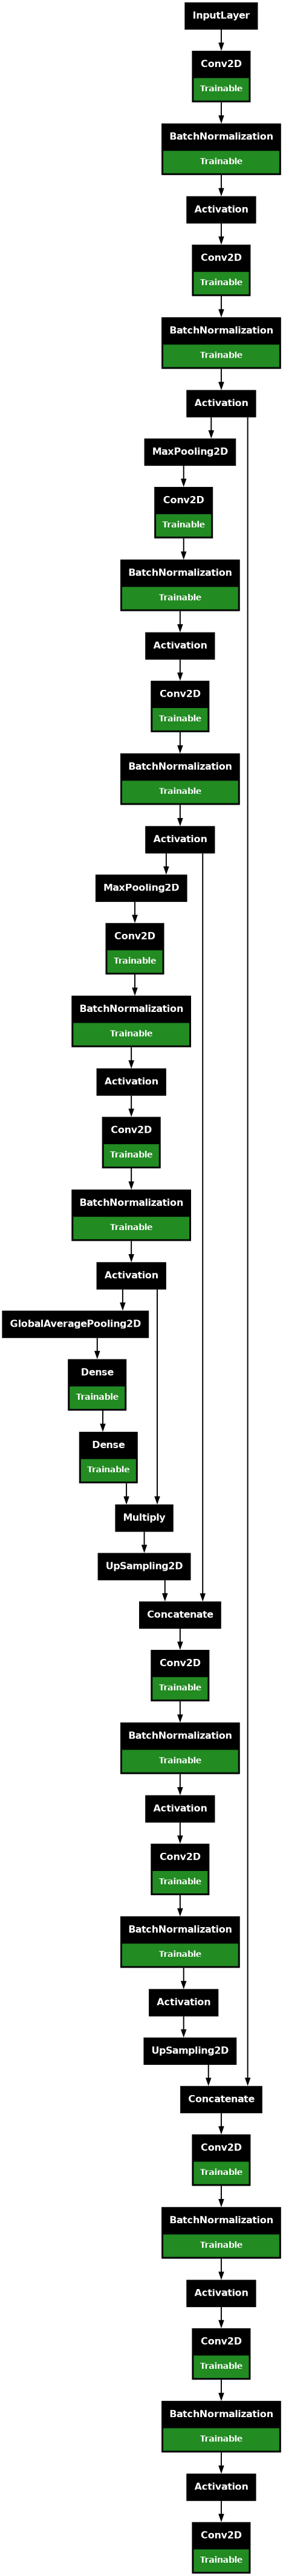

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, **kwargs):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, **kwargs)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, frequency=5):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            idx = np.random.randint(0, len(self.X_train))
            image = self.X_train[idx]
            label = self.y_train[idx]


            image = np.expand_dims(image, axis=0)

            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]

            class_colors = ['black', 'brown', 'gray', 'yellow', 'red']
            num_classes = len(class_colors)
            colormap = ListedColormap(class_colors)

            plt.figure(figsize=(16, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(image[0, :, :, 0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(label, cmap=colormap, vmin=0, vmax=num_classes - 1)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred, cmap=colormap, vmin=0, vmax=num_classes - 1)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

In [ ]:
from tensorflow.keras.saving import register_keras_serializable

def compute_class_weights(y_train_augmented, num_classes=5):
    """
    Compute class weights for segmentation masks.

    Args:
        y_train (list of numpy arrays): List of segmentation masks.
        num_classes (int): Total number of classes.

    Returns:
        numpy array: Array of class weights.
    """
    class_pixel_counts = np.zeros(num_classes, dtype=np.float64)
    total_pixels = 0

    # Count the total number of pixels for each class
    for mask in y_train_augmented:
        for class_id in range(num_classes):
            class_pixel_counts[class_id] += np.sum(mask == class_id)
        total_pixels += mask.size

    # Avoid division by zero by adding a small epsilon to counts
    epsilon = 1e-6
    class_weights = total_pixels / (class_pixel_counts + epsilon)

    # Normalize the weights so that the average is 1
    class_weights /= np.mean(class_weights)

    return class_weights

# Compute class weights for the filtered training set
class_weights = compute_class_weights(y_train_augmented, num_classes=5)

# Print the computed class weights
print(f"Computed class weights: {class_weights}")

@register_keras_serializable()
class WeightedCategoricalCrossentropy:
    def __init__(self, class_weights, ignore_class=0):
        """
        A custom loss function for weighted categorical cross-entropy with an option to ignore a specific class.

        Args:
            class_weights (numpy array or list): Array of weights for each class.
            ignore_class (int): Class to exclude from the loss calculation.
        """
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        self.ignore_class = ignore_class

    def __call__(self, y_true, y_pred):
        """
        Compute the weighted categorical cross-entropy loss.

        Args:
            y_true (tensor): Ground truth labels, shape (batch_size, height, width).
            y_pred (tensor): Predicted logits, shape (batch_size, height, width, num_classes).

        Returns:
            tensor: Weighted categorical cross-entropy loss.
        """
        # One-hot encode y_true
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(self.class_weights))

        # Apply softmax to y_pred
        y_pred_softmax = tf.nn.softmax(y_pred, axis=-1)

        # Mask out the ignore_class
        mask = tf.not_equal(y_true, self.ignore_class)  # Mask for excluding ignore_class
        mask = tf.cast(mask, tf.float32)  # Cast to float for multiplication

        # Compute pixel-wise cross-entropy
        cross_entropy = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred_softmax + 1e-6), axis=-1)

        # Apply class weights
        weights = tf.reduce_sum(y_true_one_hot * self.class_weights, axis=-1)
        weighted_cross_entropy = weights * cross_entropy

        # Apply mask to exclude ignore_class contributions
        masked_loss = weighted_cross_entropy * mask

        # Compute the mean, considering only the masked elements
        return tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

    def get_config(self):
        """
        Returns the configuration of the loss function for serialization.
        """
        return {
            'class_weights': self.class_weights.numpy().tolist(),
            'ignore_class': self.ignore_class
        }

    @classmethod
    def from_config(cls, config):
        """
        Reconstructs the class instance from the configuration dictionary.
        """
        return cls(
            class_weights=config['class_weights'],
            ignore_class=config.get('ignore_class', 0)
        )

loss_function = WeightedCategoricalCrossentropy(class_weights, ignore_class=0)

# Compile the model
print("Compiling model...")
model.compile(
    loss=loss_function,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)
print("Model compiled!")

Computed class weights: [0.29311182 0.25415489 0.2234544  0.26534464 3.96393425]
Compiling model...
Model compiled!


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback: Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_val, y_val)

# Callback: Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

Epoch 1/200


I0000 00:00:1734172913.864068      91 service.cc:145] XLA service 0x7e04bc24c570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734172913.864132      91 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/139 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.2787 - loss: 0.4681 - mean_intersection_over_union: 0.1084

I0000 00:00:1734172925.557011      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4103 - loss: 0.4413 - mean_intersection_over_union: 0.2431

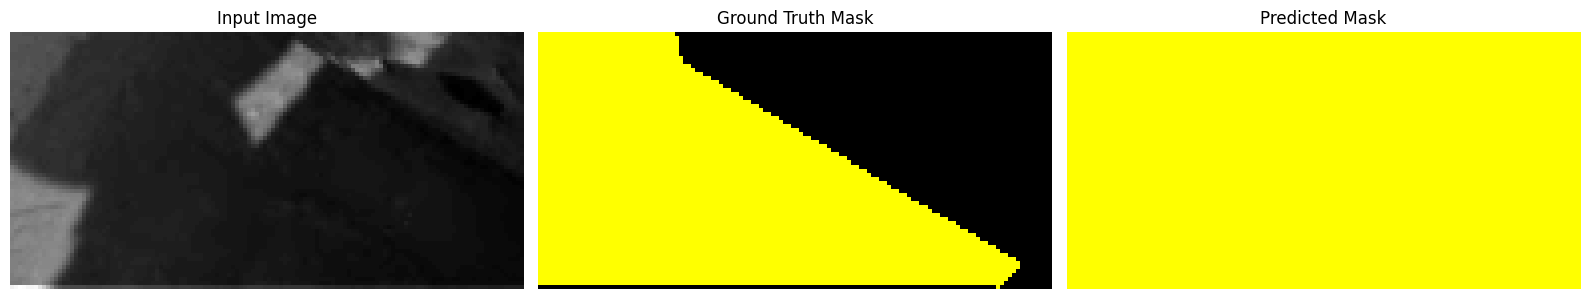

139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 0.4106 - loss: 0.4412 - mean_intersection_over_union: 0.2433 - val_accuracy: 0.2454 - val_loss: 0.3941 - val_mean_intersection_over_union: 0.0758 - learning_rate: 0.0010
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4816 - loss: 0.4012 - mean_intersection_over_union: 0.3896 - val_accuracy: 0.2454 - val_loss: 0.3952 - val_mean_intersection_over_union: 0.0758 - learning_rate: 0.0010
Epoch 3/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5527 - loss: 0.3746 - mean_intersection_over_union: 0.4761 - val_accuracy: 0.3156 - val_loss: 0.3733 - val_mean_intersection_over_union: 0.1464 - learning_rate: 0.0010
Epoch 4/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5788 - loss: 0.3642 - mean_intersection_over_union: 0.5128 - val_accuracy: 0.4608 - val_loss: 0.3291 - val_mean_intersection_over_union: 0.2793 - learning_rate: 0.0010
Epoch 5/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 

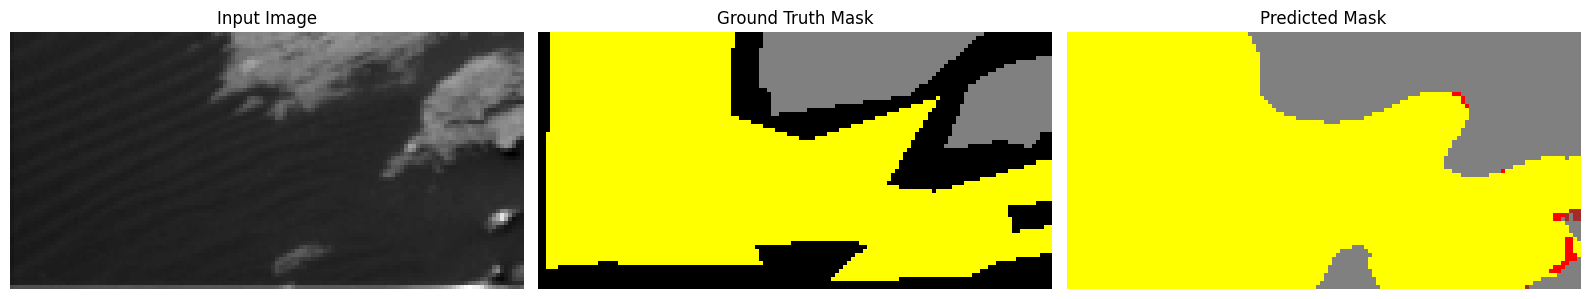

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5927 - loss: 0.3586 - mean_intersection_over_union: 0.5358 - val_accuracy: 0.4151 - val_loss: 0.3410 - val_mean_intersection_over_union: 0.2609 - learning_rate: 0.0010
Epoch 7/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5946 - loss: 0.3571 - mean_intersection_over_union: 0.5399 - val_accuracy: 0.5573 - val_loss: 0.2990 - val_mean_intersection_over_union: 0.4069 - learning_rate: 0.0010
Epoch 8/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6278 - loss: 0.3456 - mean_intersection_over_union: 0.6027 - val_accuracy: 0.5012 - val_loss: 0.3147 - val_mean_intersection_over_union: 0.3439 - learning_rate: 0.0010
Epoch 9/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6060 - loss: 0.3541 - mean_intersection_over_union: 0.5528 - val_accuracy: 0.5753 - val_loss: 0.2982 - val_mean_intersection_over_union: 0.4371 - learning_rate: 0.0010
Epoch 10/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0

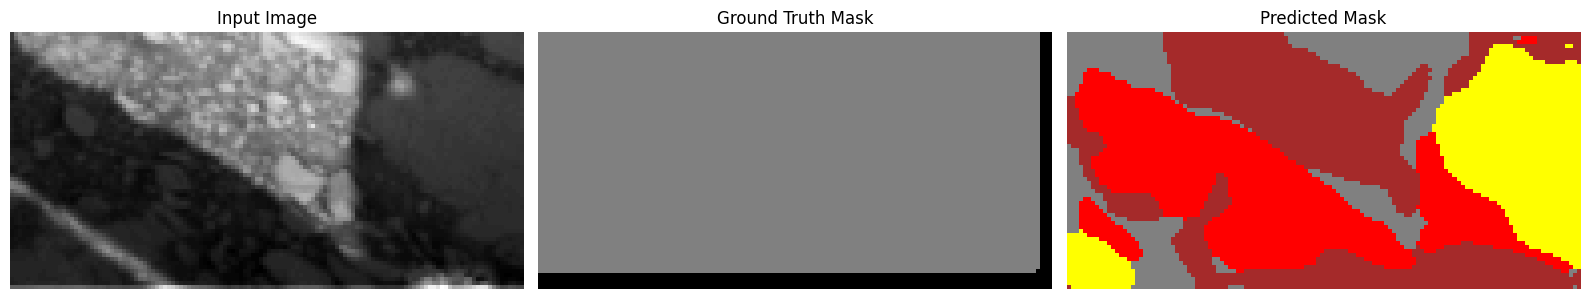

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6424 - loss: 0.3403 - mean_intersection_over_union: 0.6306 - val_accuracy: 0.6115 - val_loss: 0.2851 - val_mean_intersection_over_union: 0.4799 - learning_rate: 0.0010
Epoch 12/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6449 - loss: 0.3388 - mean_intersection_over_union: 0.6347 - val_accuracy: 0.6773 - val_loss: 0.2680 - val_mean_intersection_over_union: 0.5707 - learning_rate: 0.0010
Epoch 13/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6528 - loss: 0.3364 - mean_intersection_over_union: 0.6558 - val_accuracy: 0.6425 - val_loss: 0.2767 - val_mean_intersection_over_union: 0.5205 - learning_rate: 0.0010
Epoch 14/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6530 - loss: 0.3360 - mean_intersection_over_union: 0.6497 - val_accuracy: 0.6063 - val_loss: 0.2866 - val_mean_intersection_over_union: 0.4694 - learning_rate: 0.0010
Epoch 15/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy

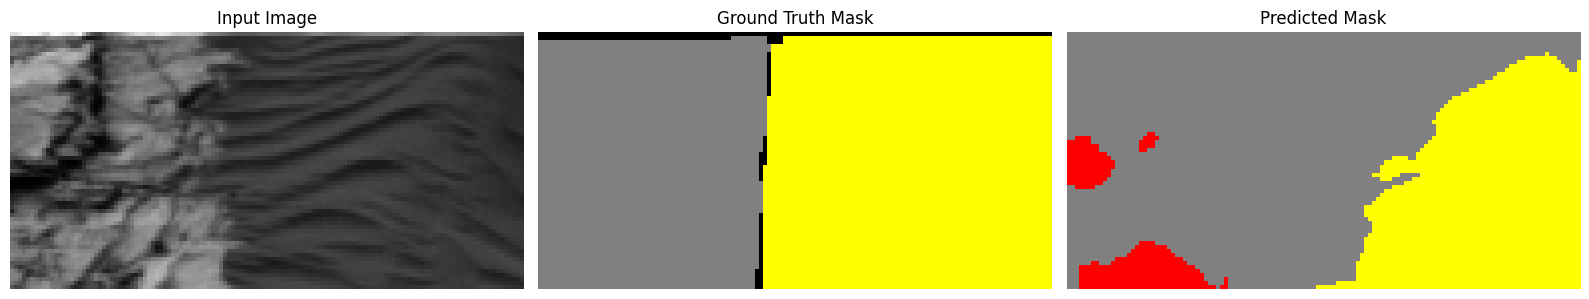

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6621 - loss: 0.3331 - mean_intersection_over_union: 0.6732 - val_accuracy: 0.6789 - val_loss: 0.2657 - val_mean_intersection_over_union: 0.5705 - learning_rate: 0.0010
Epoch 17/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6725 - loss: 0.3292 - mean_intersection_over_union: 0.7076 - val_accuracy: 0.6534 - val_loss: 0.2752 - val_mean_intersection_over_union: 0.5344 - learning_rate: 0.0010
Epoch 18/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6641 - loss: 0.3321 - mean_intersection_over_union: 0.6817 - val_accuracy: 0.6510 - val_loss: 0.2748 - val_mean_intersection_over_union: 0.5209 - learning_rate: 0.0010
Epoch 19/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6747 - loss: 0.3285 - mean_intersection_over_union: 0.7082 - val_accuracy: 0.6821 - val_loss: 0.2650 - val_mean_intersection_over_union: 0.5695 - learning_rate: 0.0010
Epoch 20/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy

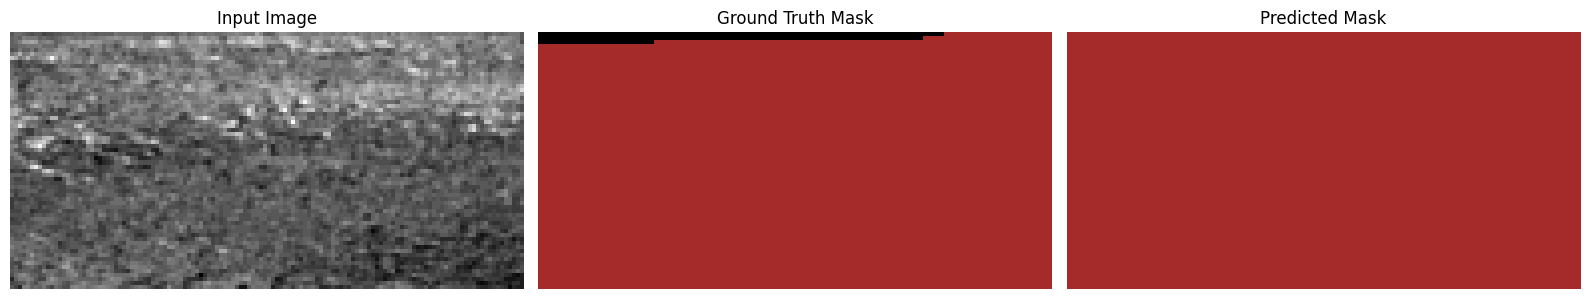

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6795 - loss: 0.3268 - mean_intersection_over_union: 0.7170 - val_accuracy: 0.6647 - val_loss: 0.2705 - val_mean_intersection_over_union: 0.5463 - learning_rate: 0.0010
Epoch 22/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6832 - loss: 0.3257 - mean_intersection_over_union: 0.7335 - val_accuracy: 0.6938 - val_loss: 0.2616 - val_mean_intersection_over_union: 0.5882 - learning_rate: 0.0010
Epoch 23/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6905 - loss: 0.3232 - mean_intersection_over_union: 0.7569 - val_accuracy: 0.5730 - val_loss: 0.3002 - val_mean_intersection_over_union: 0.4273 - learning_rate: 0.0010
Epoch 24/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6818 - loss: 0.3265 - mean_intersection_over_union: 0.7189 - val_accuracy: 0.6797 - val_loss: 0.2657 - val_mean_intersection_over_union: 0.5622 - learning_rate: 0.0010
Epoch 25/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy

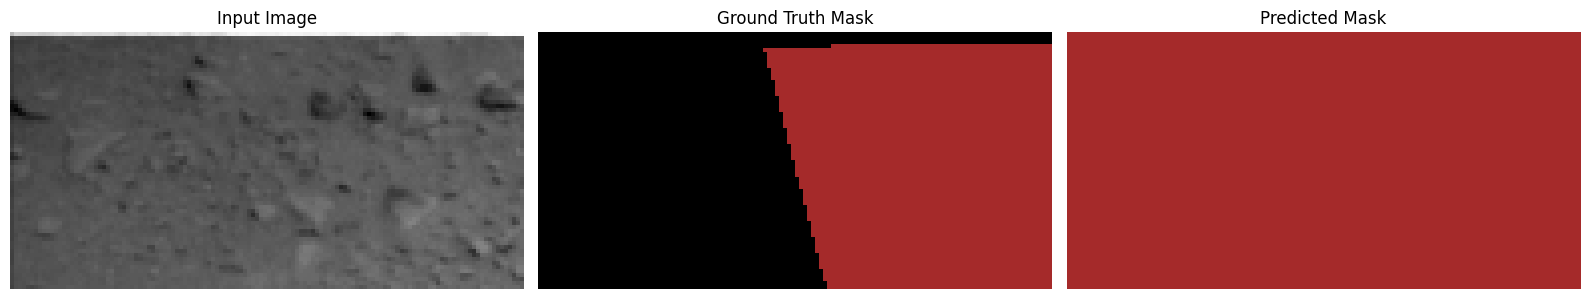

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6940 - loss: 0.3220 - mean_intersection_over_union: 0.7619 - val_accuracy: 0.6745 - val_loss: 0.2679 - val_mean_intersection_over_union: 0.5624 - learning_rate: 0.0010
Epoch 27/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6975 - loss: 0.3209 - mean_intersection_over_union: 0.7556 - val_accuracy: 0.6977 - val_loss: 0.2605 - val_mean_intersection_over_union: 0.5988 - learning_rate: 0.0010
Epoch 28/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6993 - loss: 0.3204 - mean_intersection_over_union: 0.7775 - val_accuracy: 0.5460 - val_loss: 0.3029 - val_mean_intersection_over_union: 0.4059 - learning_rate: 0.0010
Epoch 29/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6943 - loss: 0.3219 - mean_intersection_over_union: 0.7697 - val_accuracy: 0.6525 - val_loss: 0.2747 - val_mean_intersection_over_union: 0.5282 - learning_rate: 0.0010
Epoch 30/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy

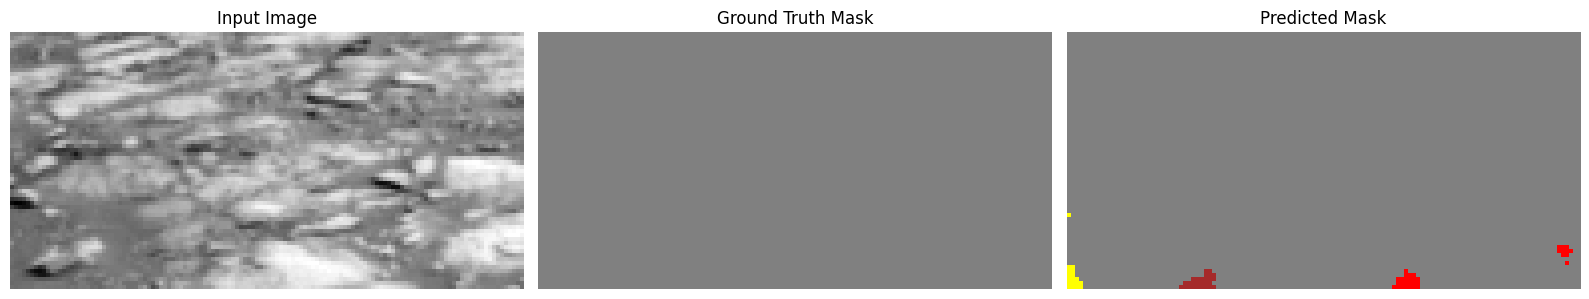

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7004 - loss: 0.3200 - mean_intersection_over_union: 0.7749 - val_accuracy: 0.6735 - val_loss: 0.2667 - val_mean_intersection_over_union: 0.5574 - learning_rate: 0.0010
Epoch 32/200
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7007 - loss: 0.3200 - mean_intersection_over_union: 0.7630
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7007 - loss: 0.3200 - mean_intersection_over_union: 0.7635 - val_accuracy: 0.7009 - val_loss: 0.2614 - val_mean_intersection_over_union: 0.6312 - learning_rate: 0.0010
Epoch 33/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7156 - loss: 0.3149 - mean_intersection_over_union: 0.8193 - val_accuracy: 0.6999 - val_loss: 0.2594 - val_mean_intersection_over_union: 0.6131 - learning_rate: 5.0000e-04
Epoch 34/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7204 - loss: 0.3134 - mean_intersecti

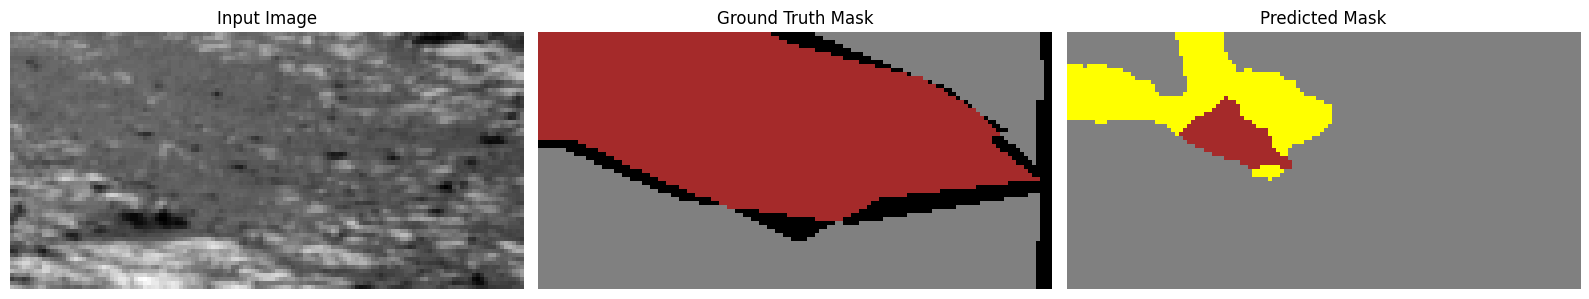

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7263 - loss: 0.3116 - mean_intersection_over_union: 0.8510 - val_accuracy: 0.6929 - val_loss: 0.2625 - val_mean_intersection_over_union: 0.5984 - learning_rate: 5.0000e-04
Epoch 37/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7275 - loss: 0.3112 - mean_intersection_over_union: 0.8500 - val_accuracy: 0.6369 - val_loss: 0.2806 - val_mean_intersection_over_union: 0.5422 - learning_rate: 5.0000e-04
Epoch 38/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7294 - loss: 0.3106 - mean_intersection_over_union: 0.8583 - val_accuracy: 0.7162 - val_loss: 0.2556 - val_mean_intersection_over_union: 0.6334 - learning_rate: 5.0000e-04
Epoch 39/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7326 - loss: 0.3096 - mean_intersection_over_union: 0.8666 - val_accuracy: 0.7117 - val_loss: 0.2566 - val_mean_intersection_over_union: 0.6322 - learning_rate: 5.0000e-04
Epoch 40/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms

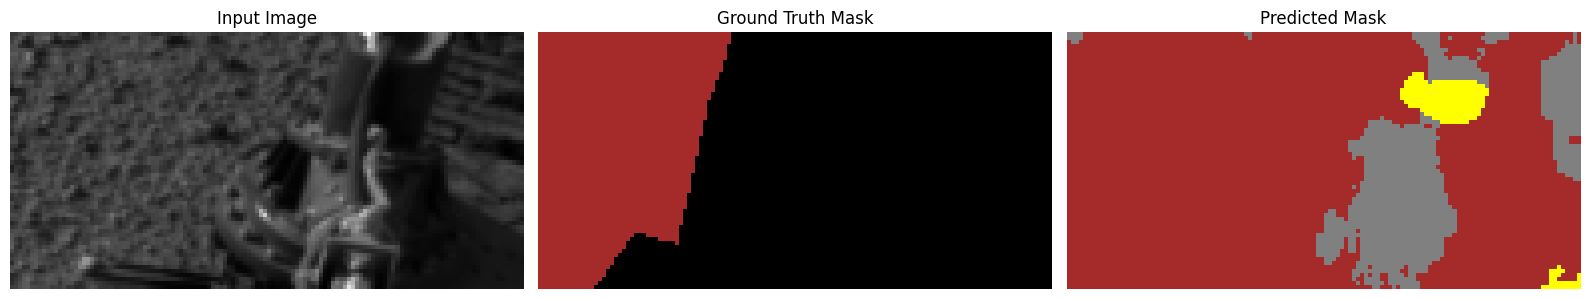

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7318 - loss: 0.3099 - mean_intersection_over_union: 0.8632 - val_accuracy: 0.7213 - val_loss: 0.2537 - val_mean_intersection_over_union: 0.6695 - learning_rate: 5.0000e-04
Epoch 42/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7347 - loss: 0.3089 - mean_intersection_over_union: 0.8681 - val_accuracy: 0.7038 - val_loss: 0.2586 - val_mean_intersection_over_union: 0.6020 - learning_rate: 5.0000e-04
Epoch 43/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7343 - loss: 0.3091 - mean_intersection_over_union: 0.8587 - val_accuracy: 0.7221 - val_loss: 0.2532 - val_mean_intersection_over_union: 0.6442 - learning_rate: 5.0000e-04
Epoch 44/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7383 - loss: 0.3078 - mean_intersection_over_union: 0.8828 - val_accuracy: 0.7128 - val_loss: 0.2564 - val_mean_intersection_over_union: 0.6764 - learning_rate: 5.0000e-04
Epoch 45/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms

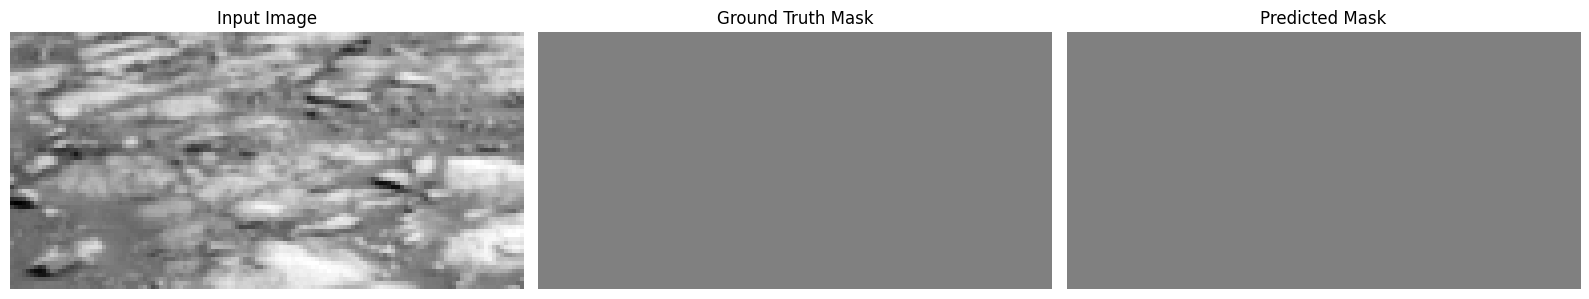

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7422 - loss: 0.3066 - mean_intersection_over_union: 0.8870 - val_accuracy: 0.7236 - val_loss: 0.2530 - val_mean_intersection_over_union: 0.6696 - learning_rate: 5.0000e-04
Epoch 47/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7414 - loss: 0.3068 - mean_intersection_over_union: 0.8887 - val_accuracy: 0.6459 - val_loss: 0.2788 - val_mean_intersection_over_union: 0.5557 - learning_rate: 5.0000e-04
Epoch 48/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7398 - loss: 0.3074 - mean_intersection_over_union: 0.8808 - val_accuracy: 0.7136 - val_loss: 0.2562 - val_mean_intersection_over_union: 0.6535 - learning_rate: 5.0000e-04
Epoch 49/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7377 - loss: 0.3080 - mean_intersection_over_union: 0.8753 - val_accuracy: 0.6989 - val_loss: 0.2599 - val_mean_intersection_over_union: 0.5949 - learning_rate: 5.0000e-04
Epoch 50/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms

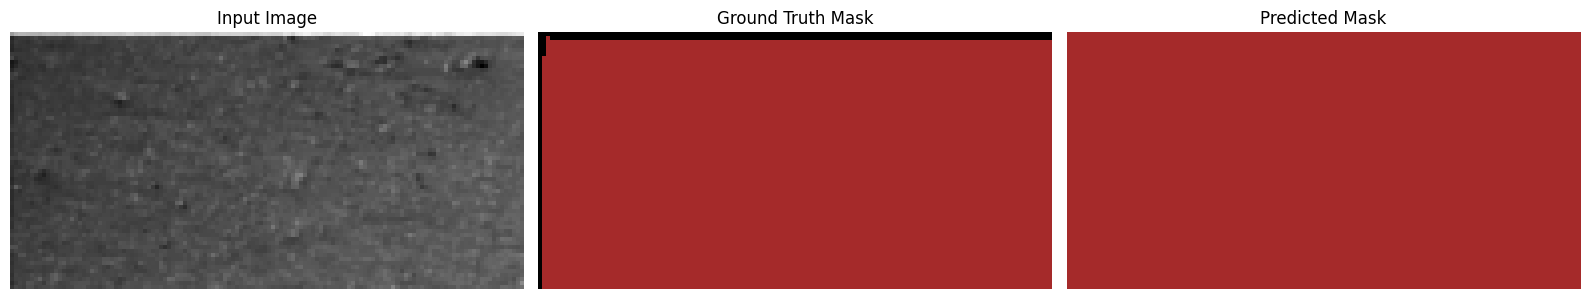


Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7447 - loss: 0.3058 - mean_intersection_over_union: 0.8842 - val_accuracy: 0.7115 - val_loss: 0.2558 - val_mean_intersection_over_union: 0.6140 - learning_rate: 5.0000e-04
Epoch 52/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7462 - loss: 0.3052 - mean_intersection_over_union: 0.8873 - val_accuracy: 0.7443 - val_loss: 0.2463 - val_mean_intersection_over_union: 0.7516 - learning_rate: 2.5000e-04
Epoch 53/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7509 - loss: 0.3038 - mean_intersection_over_union: 0.9128 - val_accuracy: 0.7385 - val_loss: 0.2476 - val_mean_intersection_over_union: 0.7248 - learning_rate: 2.5000e-04
Epoch 54/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7525 - loss: 0.3033 - mean_intersection_over_union: 0.9179 - val_accuracy: 0.7361 - val_loss: 0.2481 - val_mean_intersection_over_union: 0.7149

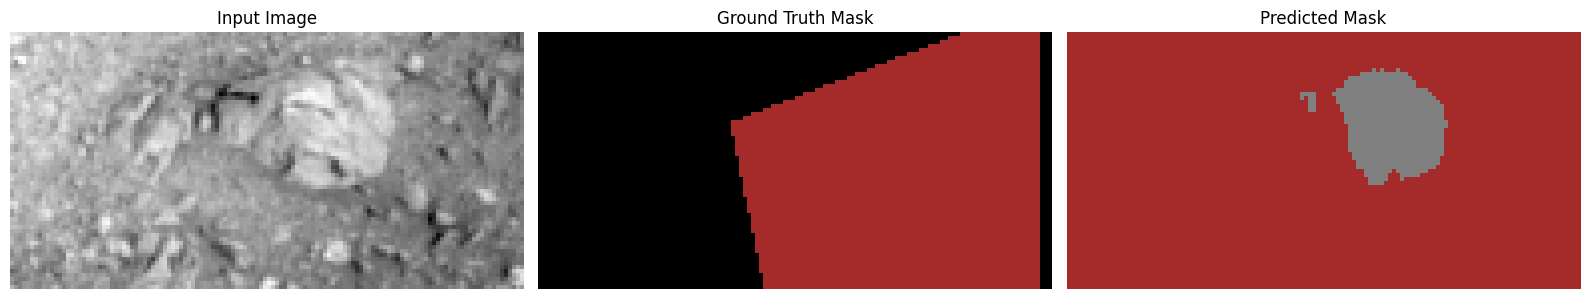

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7526 - loss: 0.3033 - mean_intersection_over_union: 0.9184 - val_accuracy: 0.7384 - val_loss: 0.2477 - val_mean_intersection_over_union: 0.7248 - learning_rate: 2.5000e-04
Epoch 57/200
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7551 - loss: 0.3025 - mean_intersection_over_union: 0.9243
Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7551 - loss: 0.3025 - mean_intersection_over_union: 0.9243 - val_accuracy: 0.7291 - val_loss: 0.2498 - val_mean_intersection_over_union: 0.6990 - learning_rate: 2.5000e-04
Epoch 58/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7565 - loss: 0.3020 - mean_intersection_over_union: 0.9277 - val_accuracy: 0.7341 - val_loss: 0.2485 - val_mean_intersection_over_union: 0.7117 - learning_rate: 1.2500e-04
Epoch 59/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7576 - loss: 0.3017 - mean_in

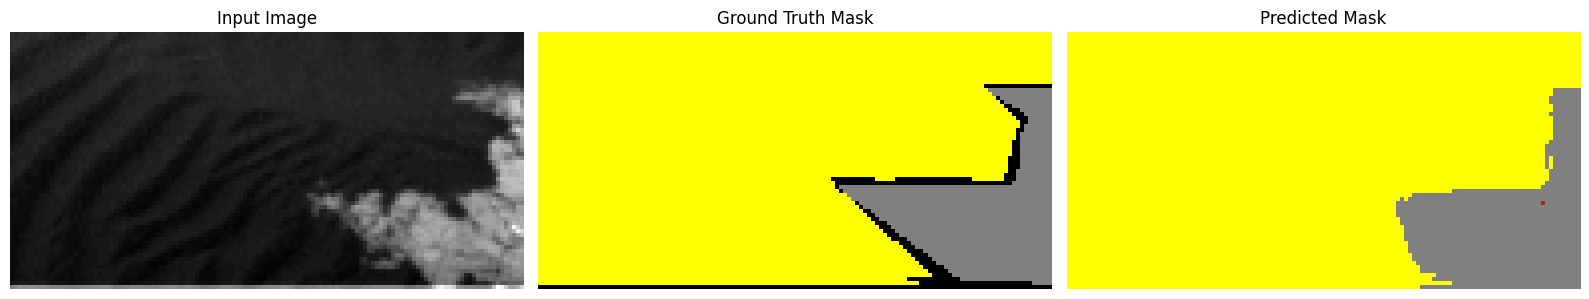

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7589 - loss: 0.3013 - mean_intersection_over_union: 0.9337 - val_accuracy: 0.7348 - val_loss: 0.2483 - val_mean_intersection_over_union: 0.7091 - learning_rate: 1.2500e-04
Epoch 62/200
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7594 - loss: 0.3012 - mean_intersection_over_union: 0.9349
Epoch 62: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7594 - loss: 0.3011 - mean_intersection_over_union: 0.9349 - val_accuracy: 0.7347 - val_loss: 0.2483 - val_mean_intersection_over_union: 0.7118 - learning_rate: 1.2500e-04
Epoch 63/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7599 - loss: 0.3010 - mean_intersection_over_union: 0.9362 - val_accuracy: 0.7394 - val_loss: 0.2473 - val_mean_intersection_over_union: 0.7220 - learning_rate: 6.2500e-05
Epoch 64/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7602 - loss: 0.3009 - mean_int

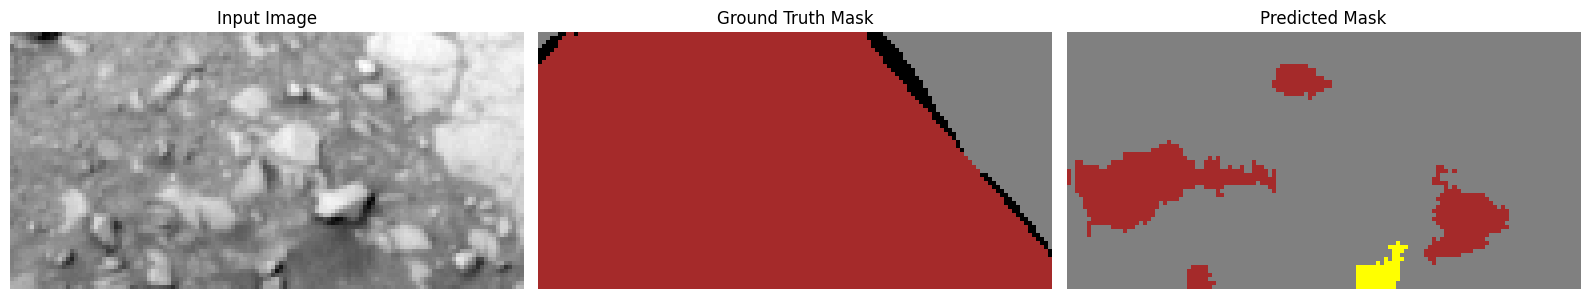

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7608 - loss: 0.3007 - mean_intersection_over_union: 0.9384 - val_accuracy: 0.7397 - val_loss: 0.2473 - val_mean_intersection_over_union: 0.7207 - learning_rate: 6.2500e-05
Epoch 67/200
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7611 - loss: 0.3006 - mean_intersection_over_union: 0.9391
Epoch 67: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7611 - loss: 0.3006 - mean_intersection_over_union: 0.9391 - val_accuracy: 0.7396 - val_loss: 0.2473 - val_mean_intersection_over_union: 0.7202 - learning_rate: 6.2500e-05
Epoch 68/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7613 - loss: 0.3005 - mean_intersection_over_union: 0.9398 - val_accuracy: 0.7409 - val_loss: 0.2471 - val_mean_intersection_over_union: 0.7243 - learning_rate: 3.1250e-05
Epoch 69/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7615 - loss: 0.3005 - mean_in

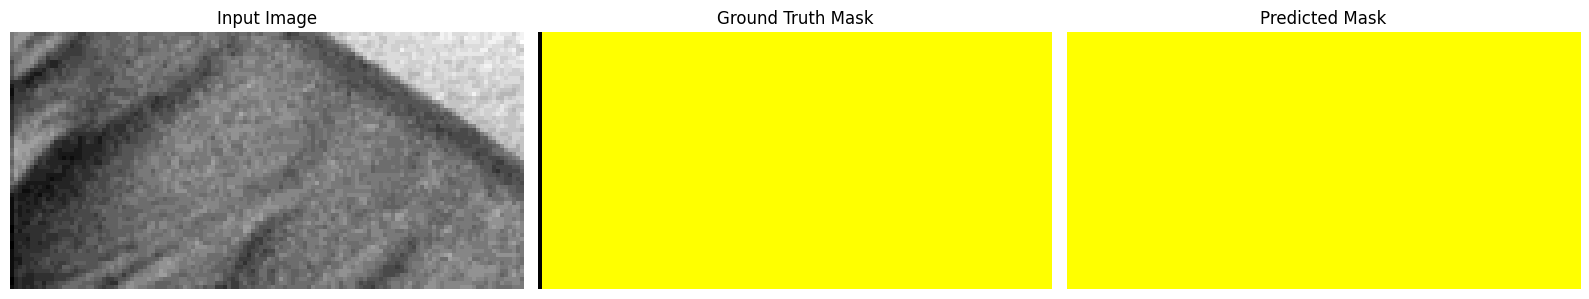

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7619 - loss: 0.3004 - mean_intersection_over_union: 0.9408 - val_accuracy: 0.7410 - val_loss: 0.2471 - val_mean_intersection_over_union: 0.7250 - learning_rate: 3.1250e-05
Epoch 72/200
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7620 - loss: 0.3004 - mean_intersection_over_union: 0.9412
Epoch 72: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7620 - loss: 0.3003 - mean_intersection_over_union: 0.9412 - val_accuracy: 0.7411 - val_loss: 0.2470 - val_mean_intersection_over_union: 0.7257 - learning_rate: 3.1250e-05
Final validation Mean Intersection Over Union: 75.16%


In [ ]:
from matplotlib.colors import ListedColormap

history = model.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, viz_callback, lr_scheduler],
    verbose=1
)


final_val_meanIoU = round(max(history.history['val_mean_intersection_over_union']) * 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

model_filename = f'UNet_valIoU{final_val_meanIoU}.keras'
model.save(model_filename)

del model


In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_valIoU75.16.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Crea il file CSV nella directory di lavoro di Kaggle
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"/kaggle/working/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Conversione predizioni in dataframe
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved as: {submission_filename}")

Submission file saved as: /kaggle/working/submission_UNet_valIoU75.16.csv
